# 0.0 Initial

## 0.1. Import

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

from sklearn    import decomposition   as d
from matplotlib import pyplot          as plt
from sklearn    import model_selection as ms
from keras      import models          as ml
from keras      import layers          as l

from boruta                import BorutaPy
from keras.callbacks       import EarlyStopping
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from numpy                 import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display       import Image

## 0.2. Helper Functions

In [183]:
def bmi (height, weight):
    bmi = weight/((height/100)**2)
    return bmi

def mean_absolute_error (y,yhat):
    return np.mean(np.abs(y-yhat))

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs((y-yhat)))/np.mean(y)

def mean_squared_error (y,yhat):
    return np.mean(pow((yhat-y),2))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def perc (x):
    #calculate % people who had CVD
    x['%_cardio_1'] = ""
    j = len(x)
    for i in range(len(x)):
        i=i+1
        if i < j:
            p = ((x['total'][i])/(x['total'][i-1]+x['total'][i]))*100
            x['%_cardio_1'][i] = p
        else:
            exit

## 0.3. Loading Data

In [3]:
df_raw = pd.read_csv('cardio_train.csv', low_memory=False)

In [4]:
df_raw

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [6]:
print('Number of columns:', format(df1.shape[1]))
print('Number of rows:', format(df1.shape[0]))

Number of columns: 13
Number of rows: 70000


## 1.2. Data Types

In [7]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3. Check NA

In [8]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Unit change

In [9]:
#age (int)
df1['age'] = (df1['age']/365).astype(int)

#weight (int)
df1['weight'] = df1['weight'].astype(int)

df1.dtypes

id             int64
age            int32
gender         int64
height         int64
weight         int32
ap_hi          int64
ap_lo          int64
cholesterol    int64
gluc           int64
smoke          int64
alco           int64
active         int64
cardio         int64
dtype: object

## 1.5. Descriptive Statiscal

In [10]:
#central tendency - mean, median
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df1.apply(min)).T
d2 = pd.DataFrame(df1.apply(max)).T
d3 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1.apply(np.std)).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,29.0,64.0,35.0,52.840671,53.0,6.766725,-0.305744,-0.818981
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.204329,72.0,14.395850,1.012030,2.586746
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0. Feature Engineering

In [151]:
df2 = df1.copy()

**Identification**

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code | 1 - women | 2 - men



**Review of Systems**

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

**Habits**

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

**Target Variable**

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

## 2.1 Mind Map Hypothesis

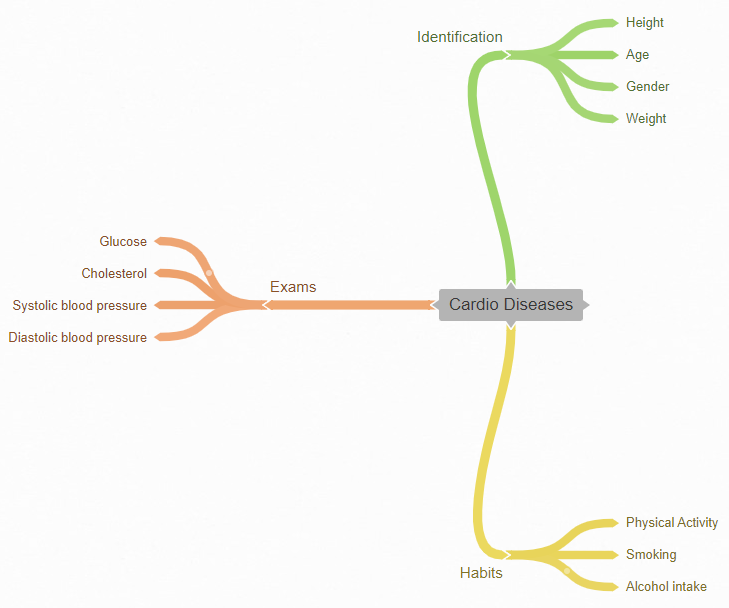

In [12]:
Image('CCD.png')

## 2.2 Hypothesis Creation

### 2.1.1 Identification Hypothesis

**1.** People over 50 are 20% more likely to have CVDs

**2.** People shorter than 170 cm (5'7'') have a 5% chance of CVDs

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have a 40% chance of having a CVD

**5.** People with a BMI above 30 (obese class I) have a 25% chance of having a CVD

### 2.1.2 Habits Hypothesis

**1.** People who do not engage in physical activity are 40% more likely to have CDCs

**2.** People who regularly consume alcohol have a 10% chance of having CVD

**3.** People who smoke are 20% more likely to have CVD

### 2.1.3 Exams Hypothesis

**1.** People who have well above normal cholesterol have a 50% chance of having CVD

**2.** People who have well above normal glucose have a 20% chance of having CVD

**3.** People who have high diastolic blood pressure have a 40% chance of having CVD

**4.** People who have high systolic blood pressure have a 40% chance of having CVD

## 2.3. Final Hypothesis

**1.** People over 50 are 20% more likely to have CVDs

**2.** People shorter than 170 cm (5'7'') have a 5% chance of CVDs

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have a 40% chance of having a CVD

**5.** People with a BMI above 30 (obese class I) have a 25% chance of having a CVD

**6.** People who do not engage in physical activity are 40% more likely to have CVDs

**7.** People who regularly consume alcohol have a 10% chance of having CVD

**8.** People who smoke are 20% more likely to have CVD

**9.** People who have well above normal cholesterol have a 50% chance of having CVD

**10.** People who have well above normal glucose have a 20% chance of having CVD

**11.** People who have high blood pressure have a 40% chance of having CVD

## 2.4. Feature Engineering

In [152]:
#BMI
df2['bmi'] = bmi(df2['height'], df2['weight'])

In [153]:
#blood pressure classification
df2['blood_pressure'] = ''

df2['blood_pressure'] = df2.apply(lambda x: '0' if (x['ap_hi'] > 0 and x['ap_hi'] < 120) and (x['ap_lo'] > 0 and x['ap_lo'] < 80) else '' 
                                  '1' if (x['ap_hi'] >= 120 and x['ap_hi'] <= 129) and (x['ap_lo'] < 80) else ''
                                  '2' if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) or (x['ap_lo'] >= 80 and x['ap_lo'] <= 89) else ''
                                  '3' if (x['ap_hi'] >= 140 and x['ap_hi'] <= 179) or (x['ap_lo'] >= 90 and x['ap_lo'] <= 119) else ''
                                  '4' if x['ap_hi'] >= 180 or x['ap_lo'] >= 120 else '', axis=1)

df2['blood_pressure'] = pd.to_numeric(df2['blood_pressure'],errors = 'coerce')

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.000000,99999.000000,99999.000000,49978.934986,50008.000000,28857.355471,-0.001555,-1.198891,69847.0
1,age,29.000000,64.000000,35.000000,52.840036,53.000000,6.767493,-0.305462,-0.819562,69847.0
2,gender,1.000000,2.000000,1.000000,1.349521,1.000000,0.476819,0.631192,-1.601642,69847.0
3,height,55.000000,250.000000,195.000000,164.362406,165.000000,8.201354,-0.615871,7.620826,69847.0
4,weight,10.000000,200.000000,190.000000,74.204189,72.000000,14.398463,1.012081,2.586527,69847.0
5,ap_hi,-150.000000,16020.000000,16170.000000,128.825819,120.000000,154.178476,85.203499,7563.567242,69847.0
6,ap_lo,-70.000000,11000.000000,11070.000000,96.684095,80.000000,188.673502,32.080160,1422.875777,69847.0
7,cholesterol,1.000000,3.000000,2.000000,1.366888,1.000000,0.680325,1.587138,0.993546,69847.0
8,gluc,1.000000,3.000000,2.000000,1.226638,1.000000,0.572494,2.396111,4.287254,69847.0
9,smoke,0.000000,1.000000,1.000000,0.087906,0.000000,0.283159,2.910752,6.472661,69847.0


# 3.0. Data Filtering

In [172]:
df3 = df2.copy()

In [173]:
#blood pressure
df3 = df3[~df3['blood_pressure'].isna()]

#height
df3 = df3[(df3['height'] >= 140) & (df3['height'] <= 200)]

#weight
df3 = df3[(df3['weight'] >= 50) & (df3['weight'] <= 150)]

#ap_hi
df3 = df3[(df3['ap_hi'] >= 0) & (df3['ap_hi'] <= 250)]

#ap_lo
df3 = df3[(df3['ap_lo'] >= 0) & (df3['ap_lo'] <= 250)]

In [175]:
#central tendency - mean, median
ct1 = pd.DataFrame(df3.apply(np.mean)).T
ct2 = pd.DataFrame(df3.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df3.apply(min)).T
d2 = pd.DataFrame(df3.apply(max)).T
d3 = pd.DataFrame(df3.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df3.apply(np.std)).T
d5 = pd.DataFrame(df3.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df3.apply(lambda x: x.kurtosis())).T
d7 = pd.DataFrame(df3.apply(lambda x: len(x))).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6,d7]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis','total']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.000000,99999.000000,99999.000000,49924.058980,49937.500000,28839.376628,0.000423,-1.197723,67836.0
1,age,29.000000,64.000000,35.000000,52.846895,53.000000,6.756370,-0.305998,-0.814872,67836.0
2,gender,1.000000,2.000000,1.000000,1.352202,1.000000,0.477657,0.618858,-1.617062,67836.0
3,height,140.000000,198.000000,58.000000,164.592886,165.000000,7.734688,0.163962,0.071650,67836.0
4,weight,50.000000,150.000000,100.000000,74.459682,72.000000,13.754728,0.966480,1.447236,67836.0
5,ap_hi,7.000000,240.000000,233.000000,126.477888,120.000000,17.646813,0.133667,5.400074,67836.0
6,ap_lo,0.000000,190.000000,190.000000,81.424892,80.000000,9.826426,0.395915,5.976403,67836.0
7,cholesterol,1.000000,3.000000,2.000000,1.365897,1.000000,0.680148,1.591937,1.006689,67836.0
8,gluc,1.000000,3.000000,2.000000,1.226767,1.000000,0.572873,2.395493,4.281748,67836.0
9,smoke,0.000000,1.000000,1.000000,0.088434,0.000000,0.283925,2.899184,6.405458,67836.0


# 4.0. Exploratory Data Analysis

In [194]:
df4 = df3.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response variable

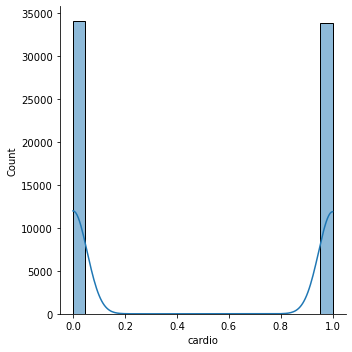

In [195]:
sns.displot(df4['cardio'], kde=True)

### 3.1.2 Numeric variable

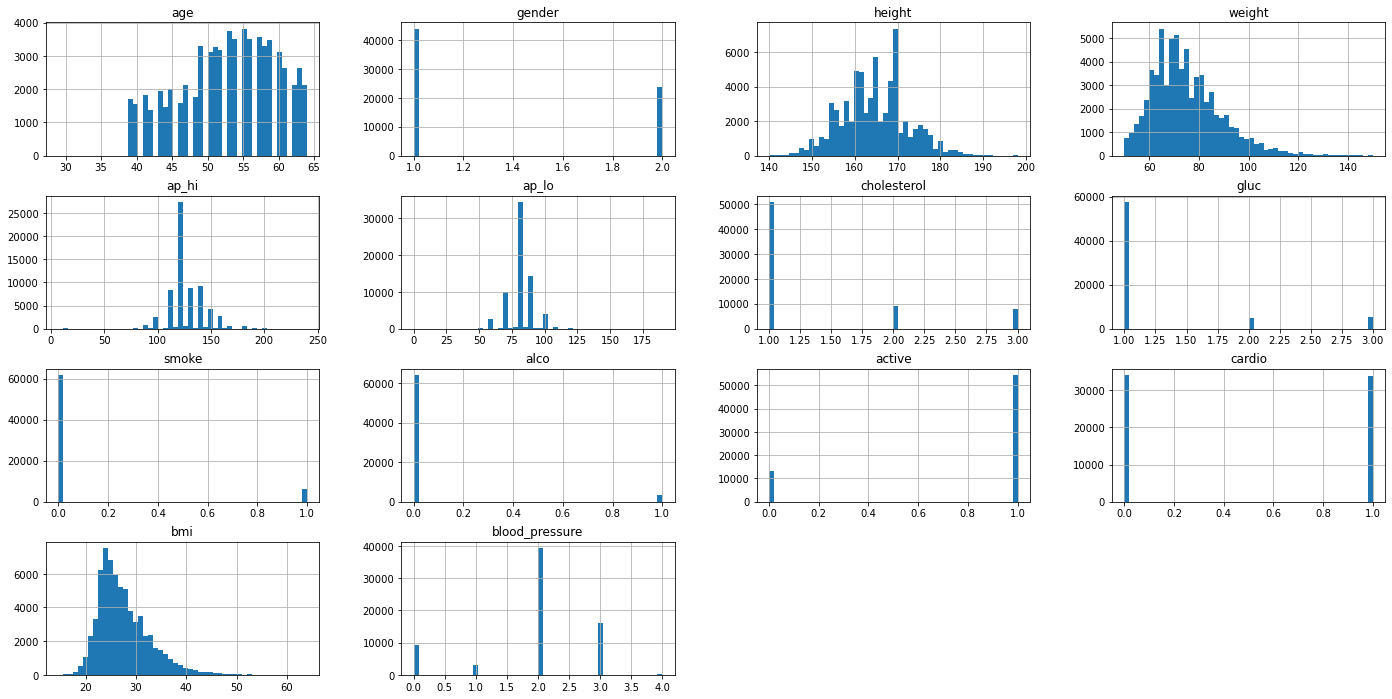

In [196]:
df42 = df4.drop('id', axis=1)
df42.hist(figsize=(24,12), bins=50);

## 3.2. Bivariate Analysis

**1. Between 39 - 64. People over 50 are on average 20% more likely to have CVD**

**TRUE** On average people over 50 are 21% more likely to have CVD. And 63 years old has the highest incidence.

<AxesSubplot:xlabel='age', ylabel='cardio'>

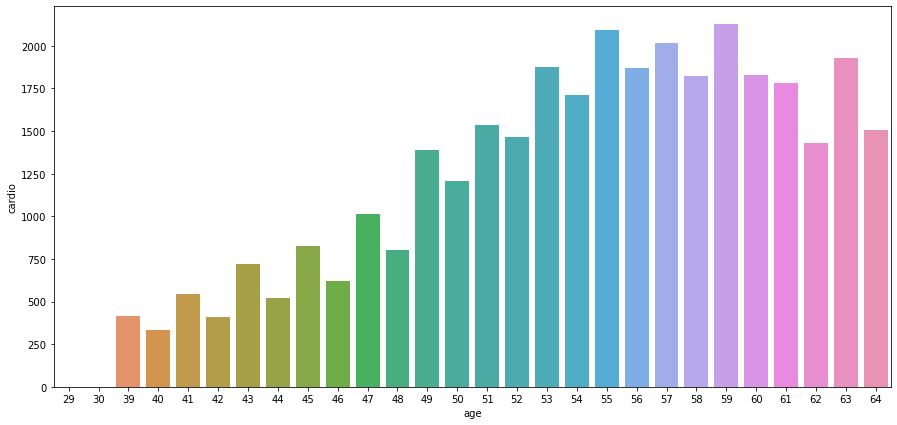

In [197]:
aux1 = df4[['age', 'cardio']].groupby('age').sum().reset_index().rename(columns={0:'total'})
#aux1

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='age', y='cardio', ax=ax, data=aux1)

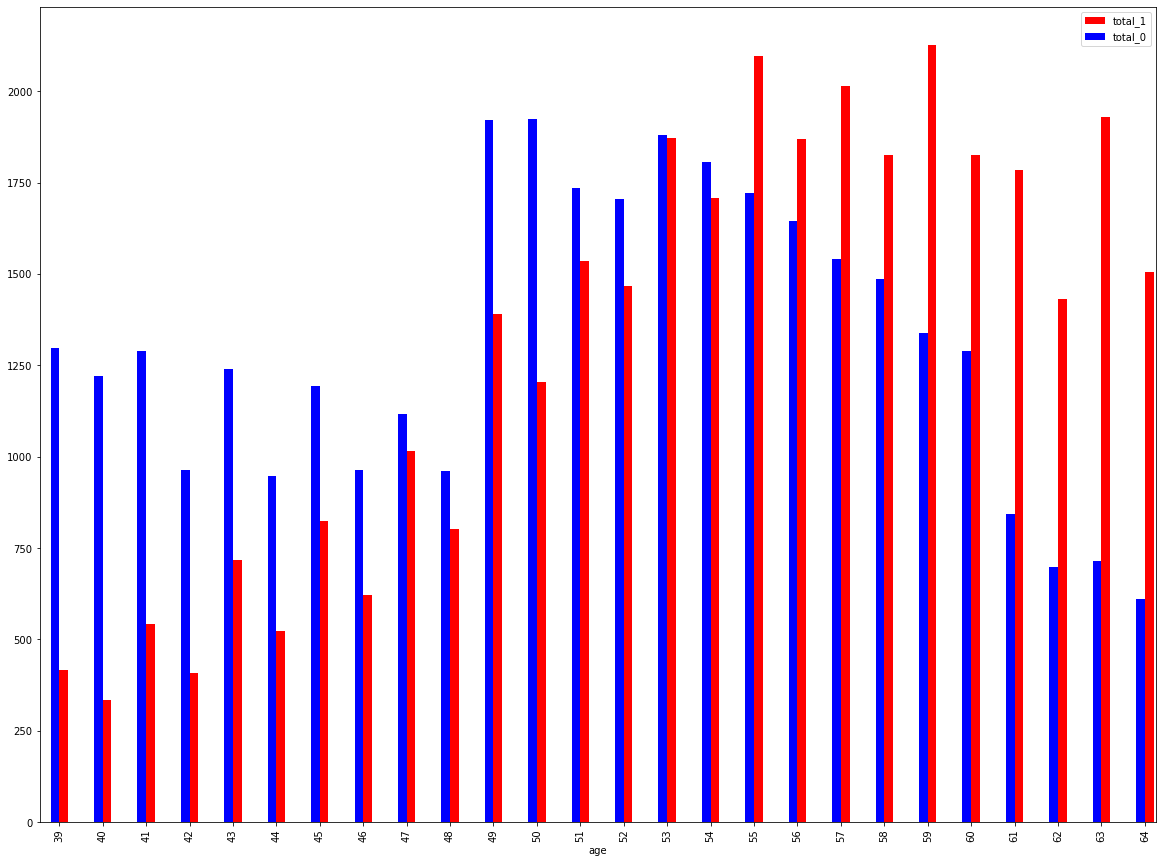

In [198]:
aux1 = df4[(df4['age'] >= 39) & (df4['cardio'] >= 1)]
aux1 = aux1[['age', 'cardio']].groupby('age').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df4[(df4['age'] >= 39) & (df4['cardio'] <= 0)]
aux2 = aux2[['age', 'cardio']].groupby('age').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx()

width = 0.2

#aux1.set_index(['cardio','bmi']).plot.bar(figsize=(20,10))
aux1.plot(x='age', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='age', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [199]:
aux1 = df4[['age', 'cardio']].groupby(['age','cardio']).size().reset_index().rename(columns={0:'total'})
#aux1

In [22]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-22-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [200]:
aux1 = perc(aux1)
aux1

<ipython-input-183-9e7f3c45d734>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [202]:
#aux1 = perc(aux1)
#aux1 = aux1[(aux1['cardio'] >=1)]
aux_50 = aux1[(aux1['age'] >= 50)]
aux_50 = pd.DataFrame(aux_50.apply(np.mean)).T
aux_50

aux_49 = aux1[(aux1['age'] < 50)]
aux_49 = pd.DataFrame(aux_49.apply(np.mean)).T
aux_49

m = pd.concat([aux_50, aux_49]).T.reset_index()
m.columns = ['index','over 50','below 50']
m

TypeError: 'NoneType' object is not subscriptable

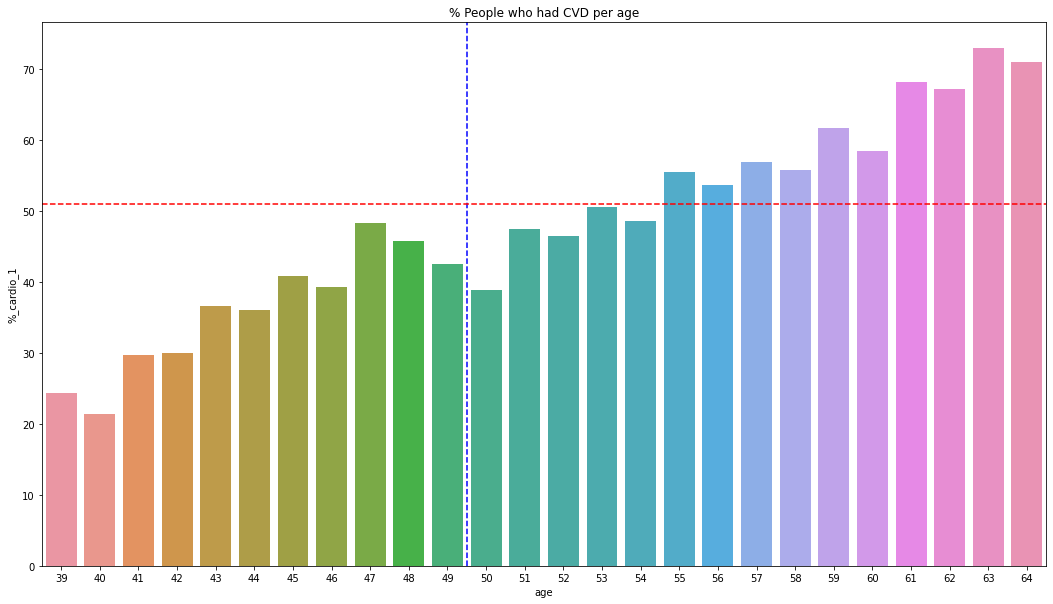

In [24]:
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='age', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(10.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per age')
plt.show()

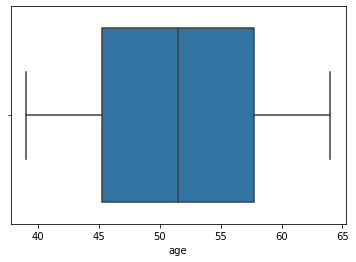

In [25]:
#boxplot age+cardio
sns.boxplot(x='age', data=aux1)
ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

In [26]:
#older than 50
#aux2 = df3[(df3['age'] > 50)]
#aux2 = aux2[['age', 'cardio']].groupby('age').sum().reset_index()
#aux2.sum()
#sns.barplot(x='age', y='count', data=aux1);

In [27]:
#younger than 50
#aux3 = df3[(df3['age'] <= 50)]
#aux3 = aux3[['age', 'cardio']].groupby('age').sum().reset_index()
#aux3.sum()

**2. Between 135 - 193. People shorter than 170 cm (5'7'') have a 5% chance of CVDs**

**FALSE** On average people shorter than 170 cm have 1% more likely to have CVD.

<AxesSubplot:xlabel='height', ylabel='cardio'>

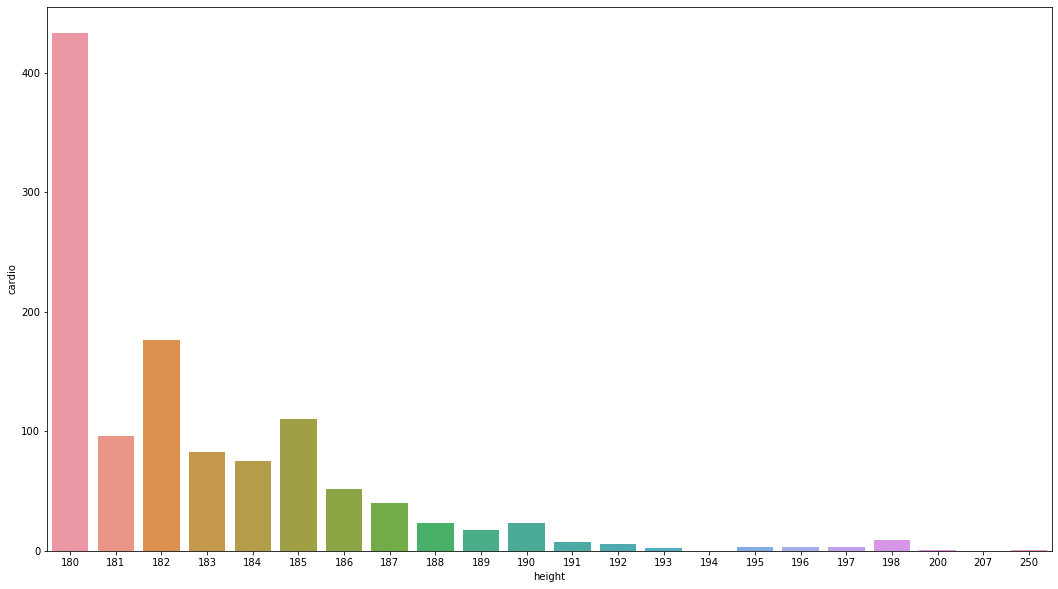

In [135]:
#histogram
aux1 = df4[(df4['height'] >= 140) & (df4['height'] <= 180)]
aux1 = aux1[['height', 'cardio']].groupby('height').sum().reset_index()

fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='height', y='cardio', ax=ax, data=aux1)

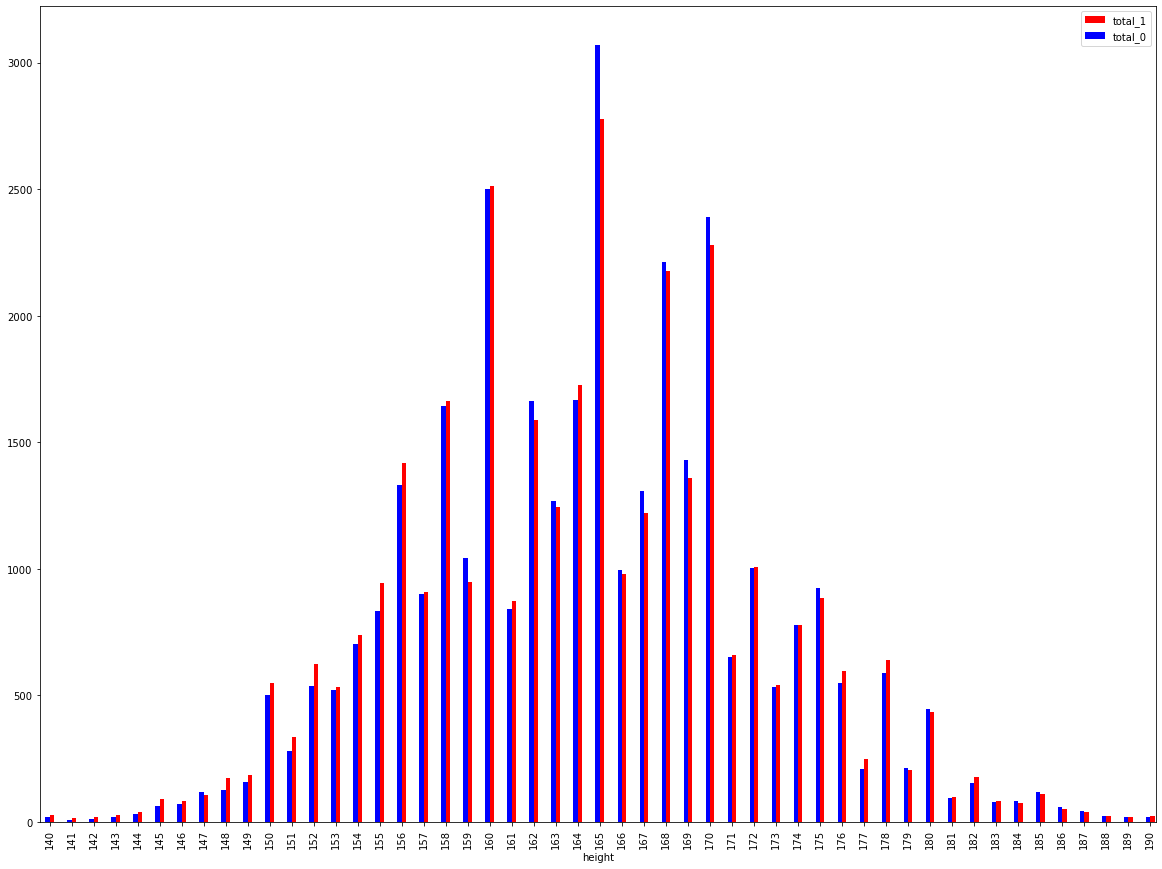

In [29]:
#histogram with and without CVD
aux1 = df4[(df4['cardio'] >= 1) & (df4['height'] >= 140) & (df4['height'] <= 190)]
aux1 = aux1[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df4[(df4['cardio'] <= 0) & (df4['height'] >= 140) & (df4['height'] <= 190)]
aux2 = aux2[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='height', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='height', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [30]:
aux1 = df4[(df4['height'] >= 135) & (df4['height'] <= 193)]
aux1 = aux1[['height', 'cardio']].groupby(['height','cardio']).size().reset_index().rename(columns={0:'total'})
#aux1

In [31]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-31-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [32]:
#aux1 = aux1[(aux1['cardio'] >= 1)]
#aux1

In [33]:
#average on CVD
aux1 = aux1[(aux1['cardio'] >= 1)]
aux_170 = aux1[(aux1['height'] >= 170)]
aux_170 = pd.DataFrame(aux_170.apply(np.mean)).T
aux_170

aux_169 = aux1[(aux1['height'] < 170)]
aux_169 = pd.DataFrame(aux_169.apply(np.mean)).T
aux_169

m = pd.concat([aux_170, aux_169]).T.reset_index()
m.columns = ['index','over 170','below 169']
m

,index,over 170,below 169
0,height,181.500000,152.000000
1,cardio,1.000000,1.000000
2,total,373.833333,739.514286
3,%_cardio_1,50.173023,51.643002


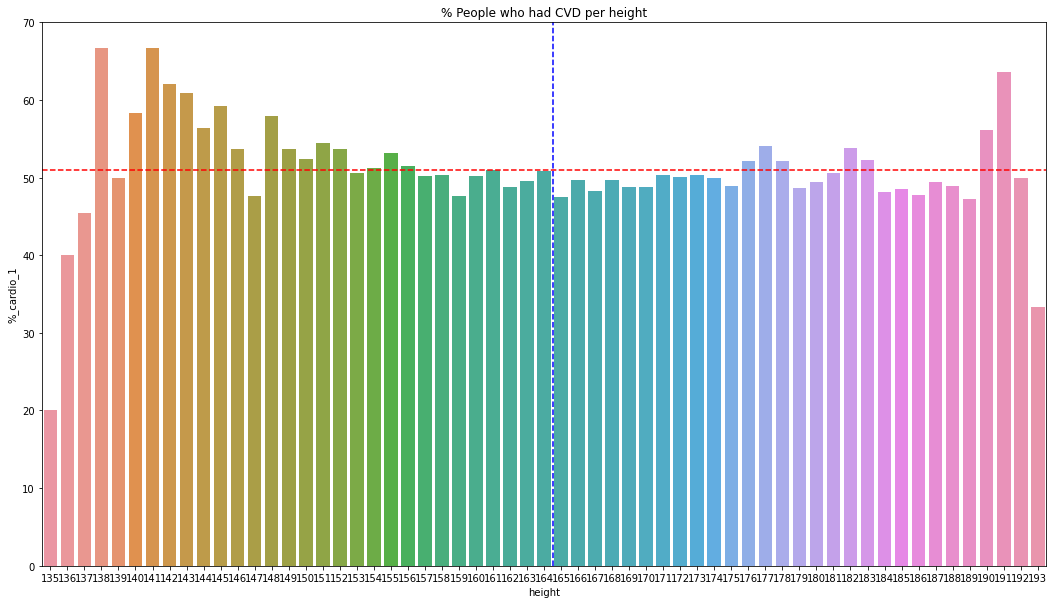

In [34]:
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='height', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per height')
plt.show()

In [35]:
#boxplot height+cardio
#aux1 = df3[['height', 'cardio']].groupby('height').sum().reset_index()
#sns.boxplot(x='height', data=aux1)

**3. Men are 30% more likely than women to develop a CVD**

**FALSE** Men had 50,5% of cases of CVD, while women had 49,7%

In [36]:
#transform to categorical
df42 = df4.copy()
df42['gender'] = df32['gender'].apply({1:'women', 2:'men'}.get)

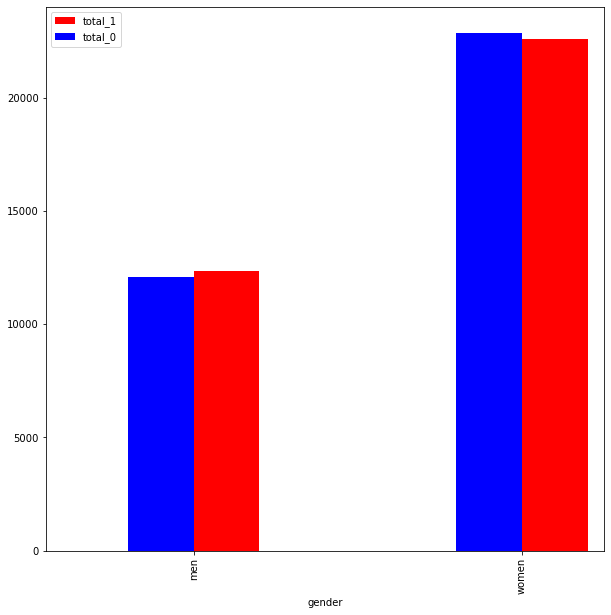

In [37]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gender', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gender', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [38]:
aux1 = df42[['gender', 'cardio']].groupby(['gender','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,gender,cardio,total
0,men,0,12063
1,men,1,12350
2,women,0,22856
3,women,1,22578


In [39]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-39-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [40]:
aux1 = aux1[(aux1['cardio'] >= 1)]

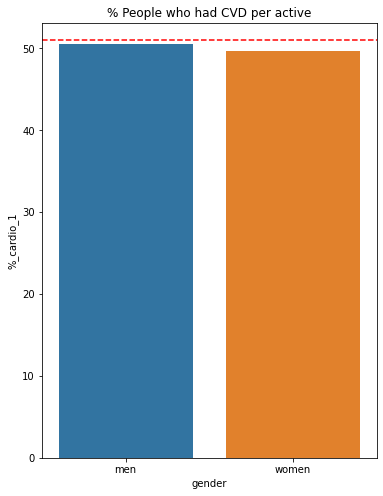

In [41]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='gender', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

In [42]:
aux1

,gender,cardio,total,%_cardio_1
1,men,1,12350,50.5878
3,women,1,22578,49.6941


**4. Between 33 - 130. People over 100 kg (220 lb) have a 40% chance of having a CVD**

**FALSE** On average people with over 100 kg have 25% more chance of having a CVD

<AxesSubplot:xlabel='weight', ylabel='cardio'>

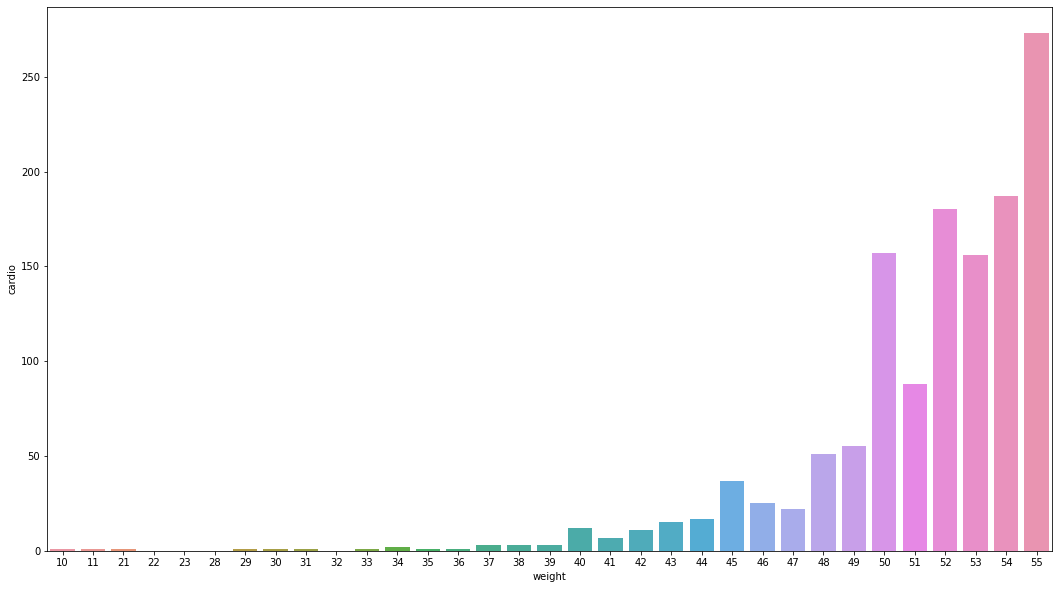

In [140]:
aux1 = df4[(df4['weight'] >= 5) & (df4['weight'] <= 55)]
aux1 = aux1[['weight', 'cardio']].groupby('weight').sum().reset_index()

fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='weight', y='cardio', ax=ax, data=aux1)

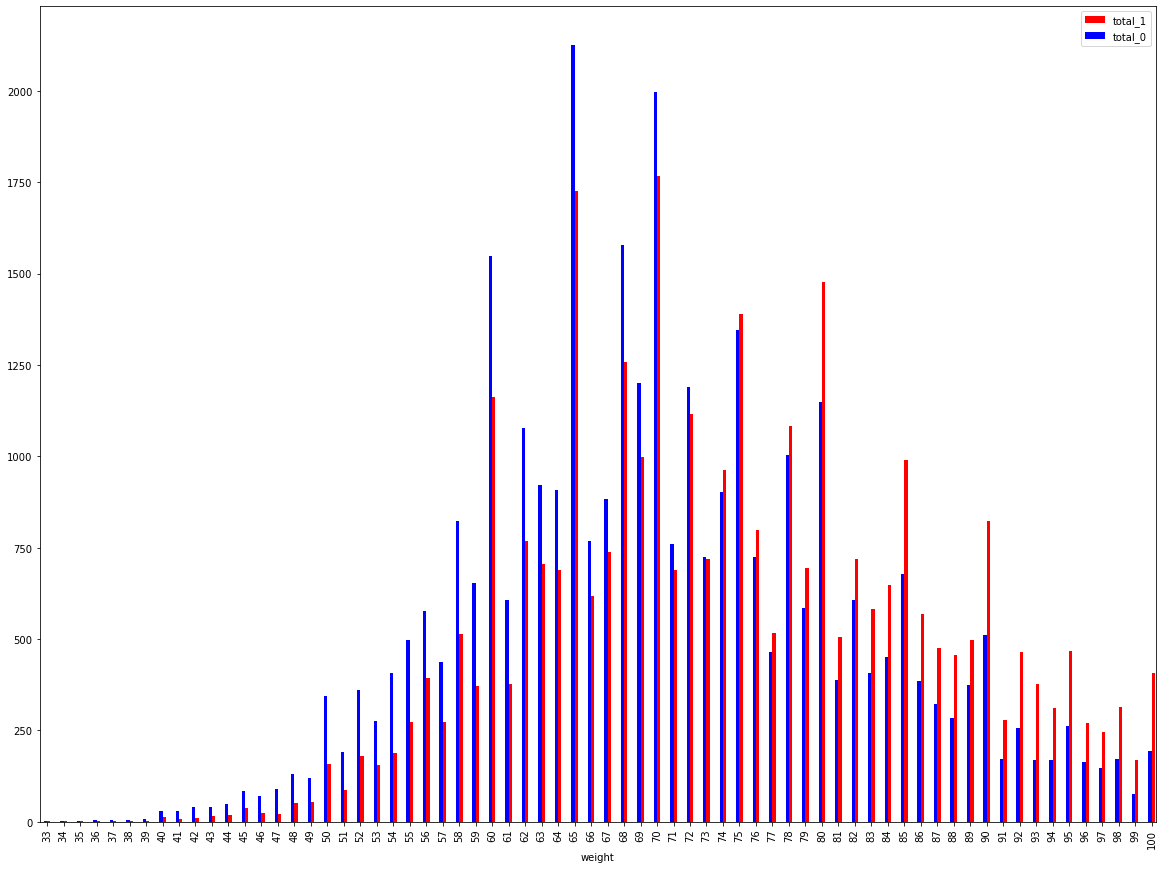

In [44]:
aux1 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] >= 1)]
aux1 = aux1[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] <= 0)]
aux2 = aux2[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='weight', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='weight', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [45]:
aux1 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 130)]
aux1 = aux1[['weight', 'cardio']].groupby(['weight','cardio']).size().reset_index().rename(columns={0:'total'})
#aux1

In [46]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-46-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [47]:
aux1 = aux1[(aux1['cardio'] >=1)]
aux_100 = aux1[(aux1['weight'] >= 100)]
aux_100 = pd.DataFrame(aux_100.apply(np.mean)).T

aux_99 = aux1[(aux1['weight'] < 100)]
aux_99 = pd.DataFrame(aux_99.apply(np.mean)).T

m = pd.concat([aux_100, aux_99]).T.reset_index()
m.columns = ['index','over 100','below 100']
m

,index,over 100,below 100
0,weight,115.000000,66.000000
1,cardio,1.000000,1.000000
2,total,80.677419,481.626866
3,%_cardio_1,70.671126,45.454211


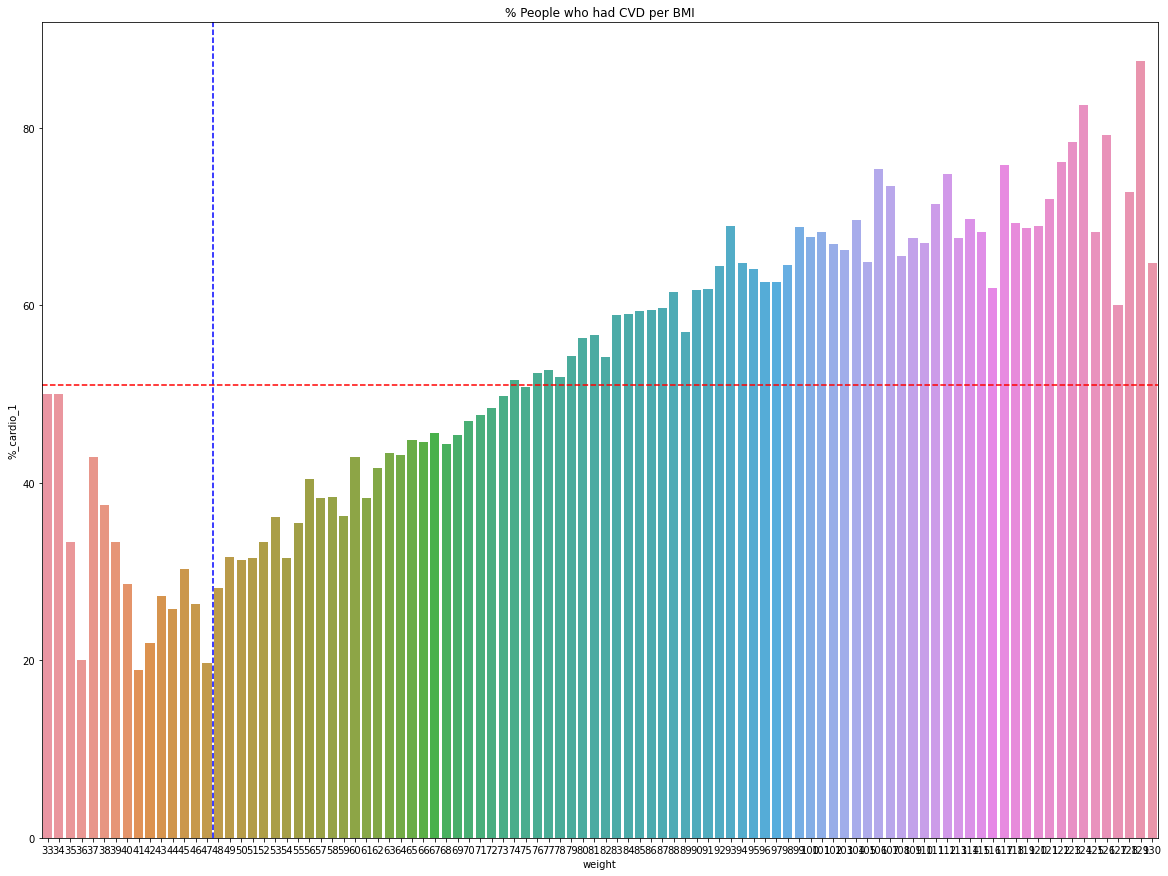

In [48]:
fig_dims = (20,15)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='weight', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(14.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

In [49]:
#boxplot weight+cardio
#aux1 = df3[['weight', 'cardio']].groupby('weight').sum().reset_index()
#sns.boxplot(x='weight', data=aux1)

**5. People with a BMI above 30 (obese class I) have a 25% chance of having a CVD**

**FALSE** People with a BMI less than 30 have 72% chance of having CVD

In [50]:
#convert type bmi (int)
df4['bmi'] = df4['bmi'].astype(int)

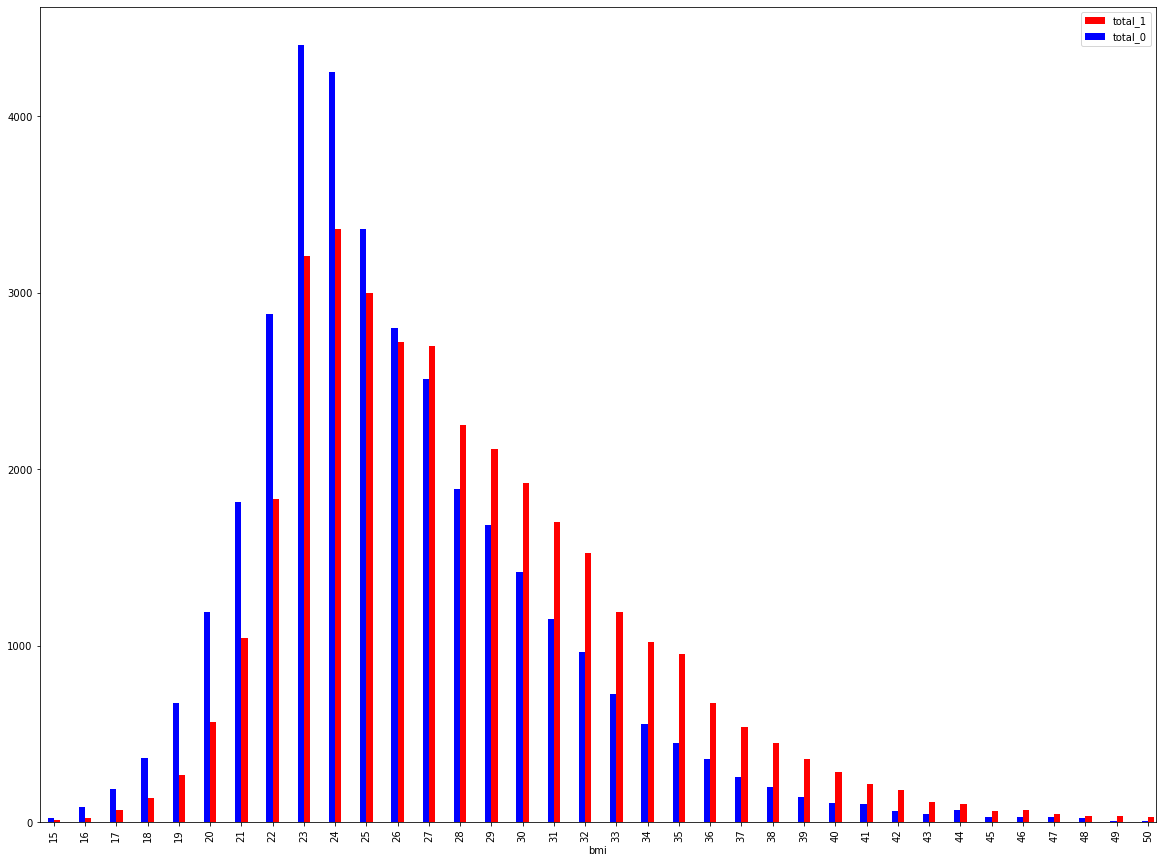

In [51]:
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50) & (df4['cardio'] >= 1)]
aux1 = aux1[['bmi', 'cardio']].groupby('bmi').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50) & (df4['cardio'] <= 0)]
aux2 = aux2[['bmi', 'cardio']].groupby('bmi').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx()

width = 0.2

#aux1.set_index(['cardio','bmi']).plot.bar(figsize=(20,10))
aux1.plot(x='bmi', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='bmi', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()
#fig_dims = (18, 10)
#fig, ax = plt.subplots(figsize=fig_dims)
#sns.barplot(x='bmi', y='total', ax=ax, data=aux1)

In [52]:
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50)]
aux1 = aux1[['bmi', 'cardio']].groupby(['bmi','cardio']).size().reset_index().rename(columns={0:'total'})
#aux1

In [53]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-53-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [54]:
aux1 = aux1[(aux1['cardio'] >=1)]
aux_30 = aux1[(aux1['bmi'] >= 30)]
aux_30 = pd.DataFrame(aux_30.apply(np.mean)).T
aux_30

aux_29 = aux1[(aux1['bmi'] < 30)]
aux_29 = pd.DataFrame(aux_29.apply(np.mean)).T
aux_29

m = pd.concat([aux_30, aux_29]).T.reset_index()
m.columns = ['index','over 30','above 30']
m

,index,over 30,above 30
0,bmi,40.000000,22.000000
1,cardio,1.000000,1.000000
2,total,547.476190,1552.400000
3,%_cardio_1,67.600503,39.125263


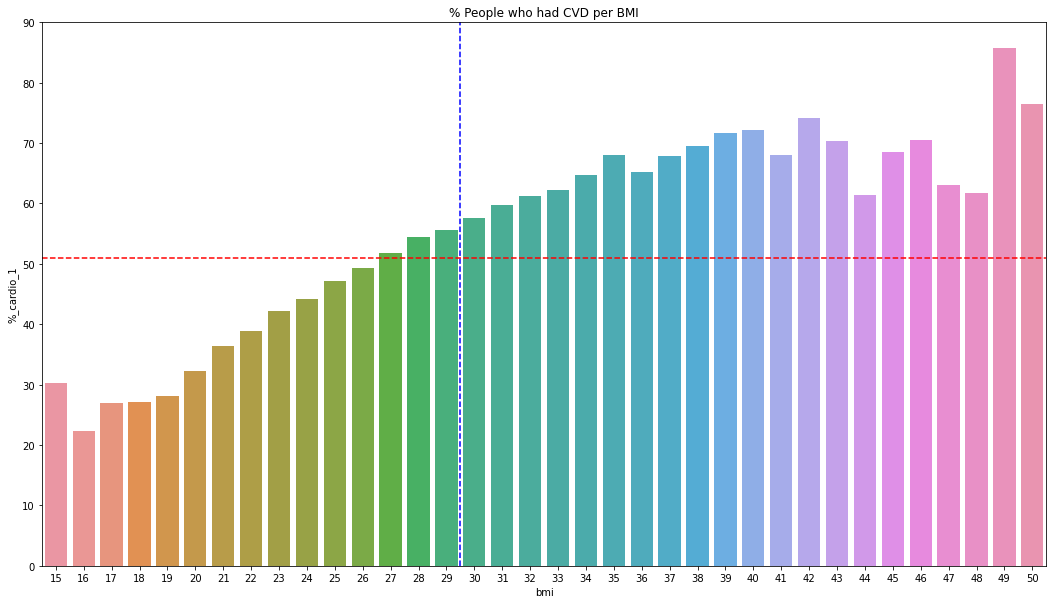

In [55]:
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='bmi', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(14.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

In [56]:
#boxplot bmi+cardio
#aux1 = df3[['bmi', 'cardio']].groupby('bmi').sum().reset_index()
#sns.boxplot(x='bmi', data=aux1)

**6. People who do not engage in physical activity are 40% more likely to have CVDs**

In [57]:
#transform to categorical
df42 = df4.copy()
df42['active'] = df32['active'].apply({0:'no', 1:'yes'}.get)

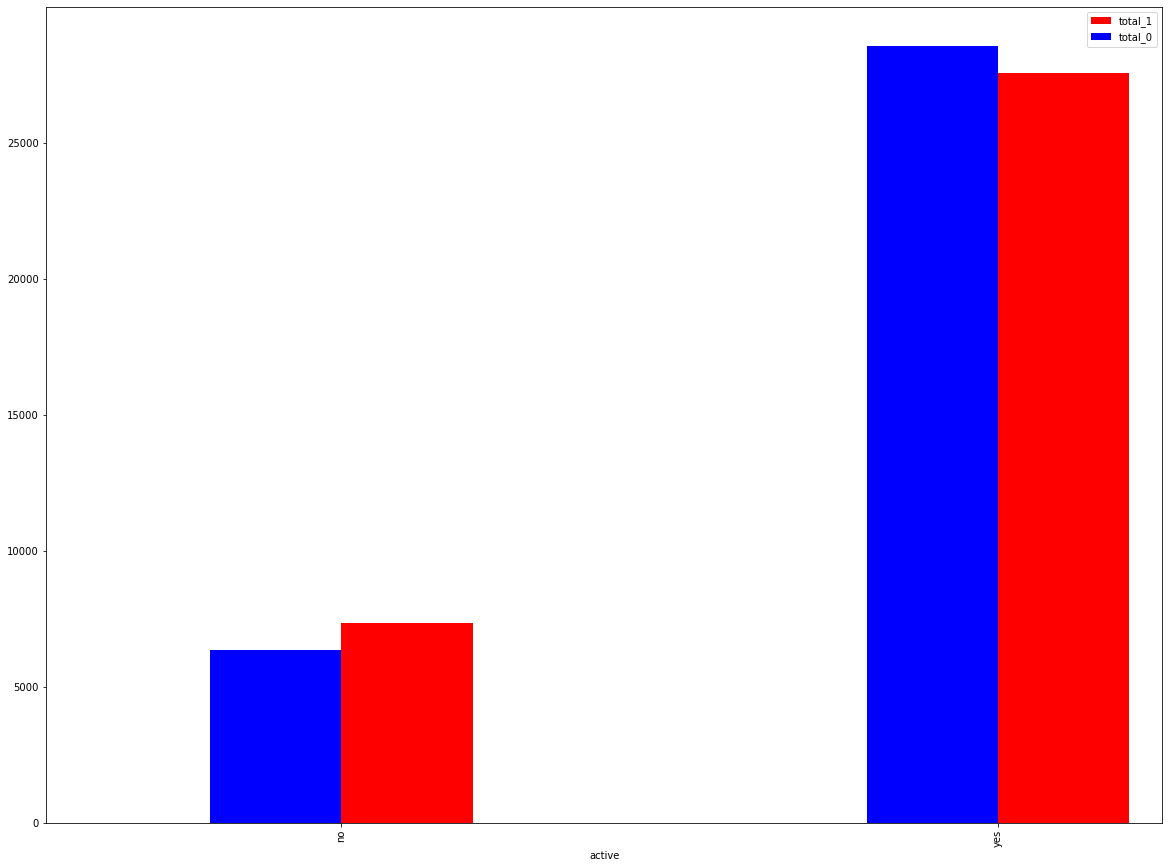

In [58]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='active', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='active', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [59]:
aux1 = df4[['active', 'cardio']].groupby(['active','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,active,cardio,total
0,0,0,6360
1,0,1,7350
2,1,0,28559
3,1,1,27578


In [60]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-60-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [61]:
aux1 = aux1[(aux1['cardio'] >= 1)]

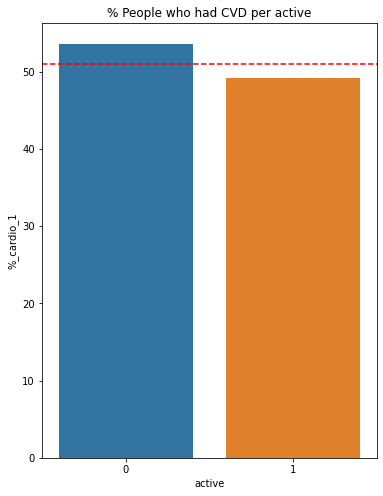

In [62]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='active', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

In [63]:
aux1

,active,cardio,total,%_cardio_1
1,0,1,7350,53.6105
3,1,1,27578,49.1262


**7. People who regularly consume alcohol have a 10% chance of having CVD**

In [64]:
#transform to categorical
df42 = df4.copy()
df42['alco'] = df42['alco'].apply({0:'no', 1:'yes'}.get)

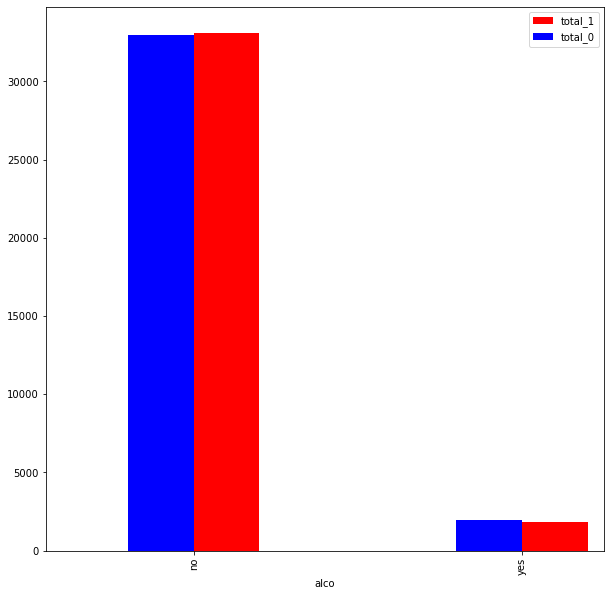

In [65]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='alco', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='alco', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [66]:
aux1 = df42[['alco', 'cardio']].groupby(['alco','cardio']).size().reset_index().reset_index().rename(columns={0:'total'})
aux1

,index,alco,cardio,total
0,0,no,0,32996
1,1,no,1,33108
2,2,yes,0,1923
3,3,yes,1,1820


In [67]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-67-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [68]:
aux1 = aux1[(aux1['cardio'] >= 1)]

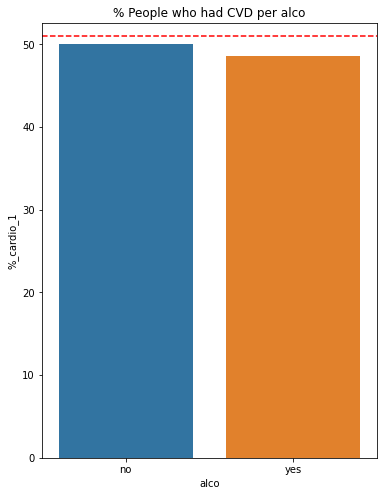

In [69]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='alco', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per alco')
plt.show()

In [70]:
aux1

,index,alco,cardio,total,%_cardio_1
1,1,no,1,33108,50.0847
3,3,yes,1,1820,48.6241


**8. People who smoke are 20% more likely to have CVD**

In [71]:
#transform to categorical
df42 = df4.copy()
df42['smoke'] = df42['smoke'].apply({0:'no', 1:'yes'}.get)

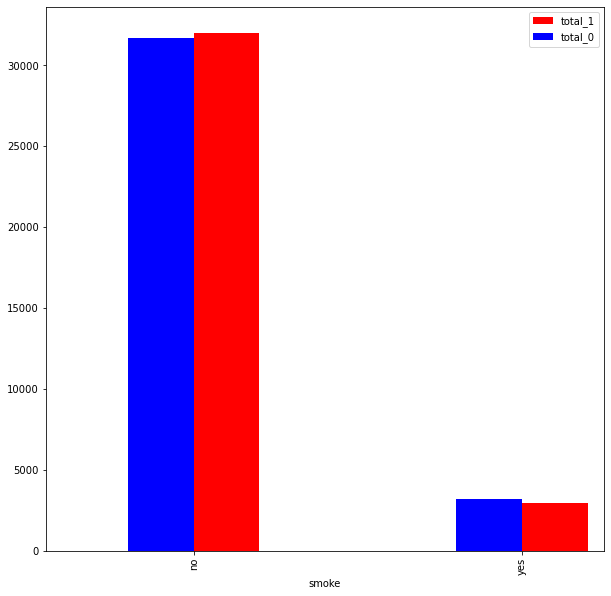

In [72]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='smoke', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='smoke', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [73]:
aux1 = df42[['smoke', 'cardio']].groupby(['smoke','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,smoke,cardio,total
0,no,0,31703
1,no,1,32004
2,yes,0,3216
3,yes,1,2924


In [74]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-74-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [75]:
aux1 = aux1[(aux1['cardio'] >= 1)]

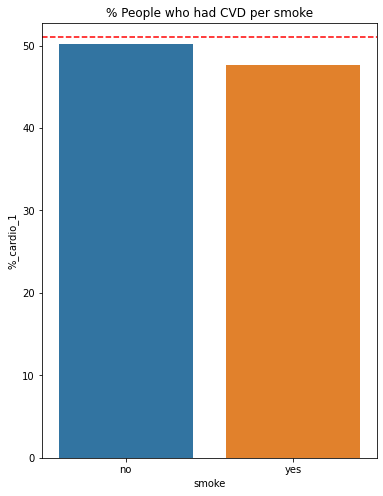

In [76]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='smoke', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per smoke')
plt.show()

In [77]:
aux1

,smoke,cardio,total,%_cardio_1
1,no,1,32004,50.2362
3,yes,1,2924,47.6221


**9. People who have well above normal cholesterol have a 50% chance of having CVD**

In [78]:
#transform to categorical
df42 = df4.copy()
df42['cholesterol'] = df42['cholesterol'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

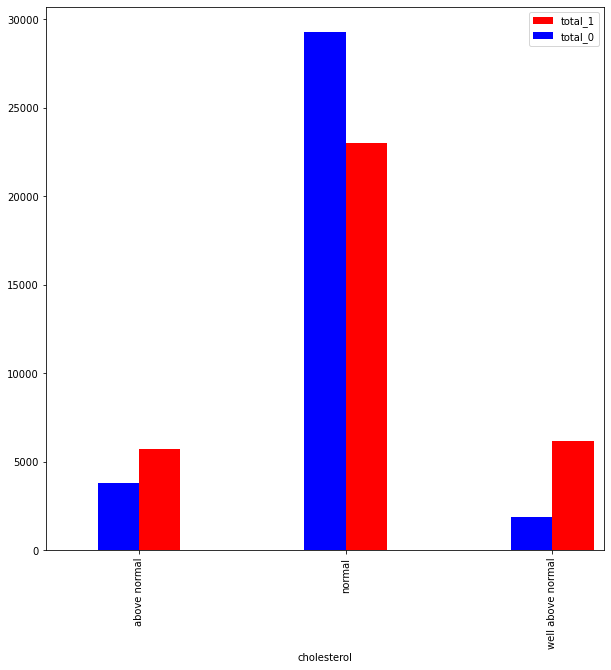

In [79]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='cholesterol', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='cholesterol', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [80]:
aux1 = df42[['cholesterol', 'cardio']].groupby(['cholesterol','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,cholesterol,cardio,total
0,above normal,0,3777
1,above normal,1,5745
2,normal,0,29254
3,normal,1,23019
4,well above normal,0,1888
5,well above normal,1,6164


In [81]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-81-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [82]:
aux1 = aux1[(aux1['cardio'] >= 1)]

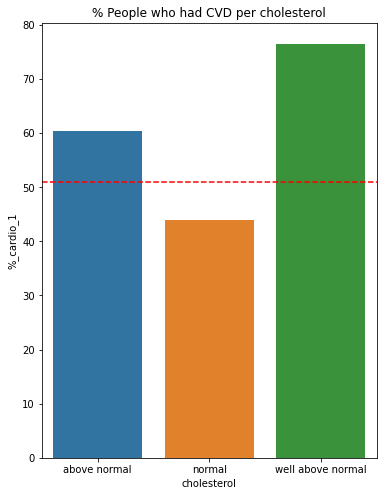

In [83]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='cholesterol', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per cholesterol')
plt.show()

In [84]:
aux1

,cholesterol,cardio,total,%_cardio_1
1,above normal,1,5745,60.334
3,normal,1,23019,44.0361
5,well above normal,1,6164,76.5524


**10. People who have well above normal glucose have a 20% chance of having CVD**

In [85]:
#transform to categorical
df42 = df4.copy()
df42['gluc'] = df42['gluc'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

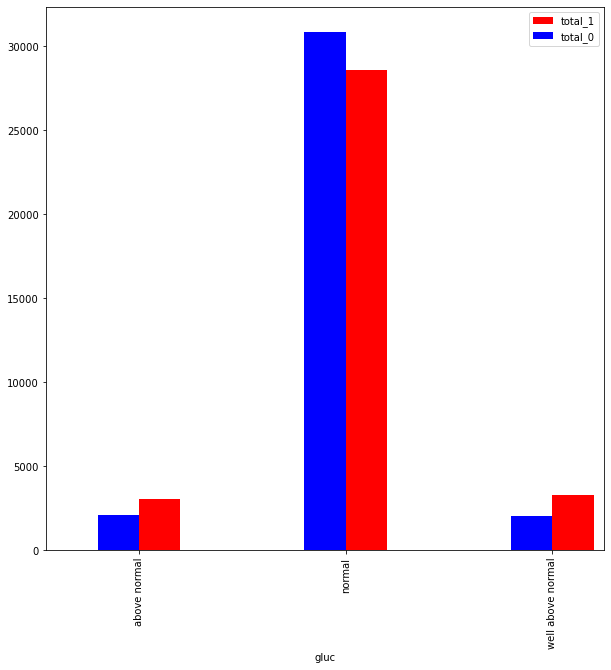

In [86]:
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gluc', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gluc', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [87]:
aux1 = df42[['gluc', 'cardio']].groupby(['gluc','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,gluc,cardio,total
0,above normal,0,2106
1,above normal,1,3074
2,normal,0,30800
3,normal,1,28542
4,well above normal,0,2013
5,well above normal,1,3312


In [88]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-88-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [89]:
aux1 = aux1[(aux1['cardio'] >= 1)]

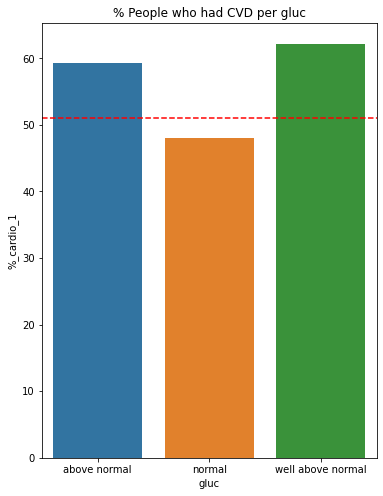

In [90]:
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='gluc', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per gluc')
plt.show()

In [91]:
aux1

,gluc,cardio,total,%_cardio_1
1,above normal,1,3074,59.3436
3,normal,1,28542,48.0975
5,well above normal,1,3312,62.1972


**11. People who hypertension have a 40% chance of having CVD**

**TRUE** On average have 50% chance of having a CVD

In [92]:
#aux1 = df3[(df3['blood_pressure'] == '')]
#aux1

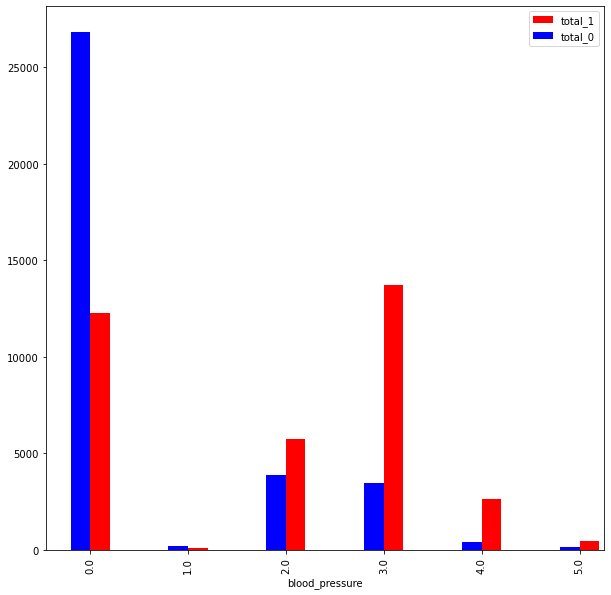

In [93]:
aux1 = df4[(df4['cardio'] >= 1)]
aux1 = aux1[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_1'})
aux1

aux2 = df4[(df4['cardio'] <= 0)]
aux2 = aux2[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_0'})
aux2

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='blood_pressure', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='blood_pressure', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [94]:
aux1 = df4[['blood_pressure', 'cardio']].groupby(['blood_pressure','cardio']).size().reset_index().rename(columns={0:'total'})
aux1

,blood_pressure,cardio,total
0,0.0,0,26809
1,0.0,1,12248
2,1.0,0,215
3,1.0,1,123
4,2.0,0,3854
5,2.0,1,5733
6,3.0,0,3478
7,3.0,1,13717
8,4.0,0,430
9,4.0,1,2630


In [95]:
#calculate % people who had CVD
aux1['%_cardio_1'] = ""

j = len(aux1)
for i in range(len(aux1)):
    i=i+1
    if i < j:
        perc = ((aux1['total'][i])/(aux1['total'][i-1]+aux1['total'][i]))*100
        aux1['%_cardio_1'][i] = perc
    else:
        exit

<ipython-input-95-f57475dde67e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['%_cardio_1'][i] = perc


In [96]:
aux1 = aux1[(aux1['cardio'] >= 1)]

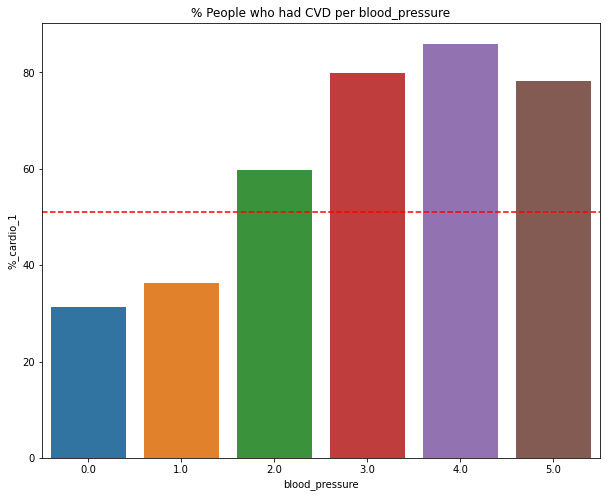

In [97]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#plt.axvline(29.5, 0.0,1.0)
graph = sns.barplot(x='blood_pressure', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per blood_pressure')
plt.show()

In [98]:
aux1

,blood_pressure,cardio,total,%_cardio_1
1,0.0,1,12248,31.3593
3,1.0,1,123,36.3905
5,2.0,1,5733,59.7997
7,3.0,1,13717,79.7732
9,4.0,1,2630,85.9477
11,5.0,1,477,78.1967


## 3.3. Multivariate Analysis

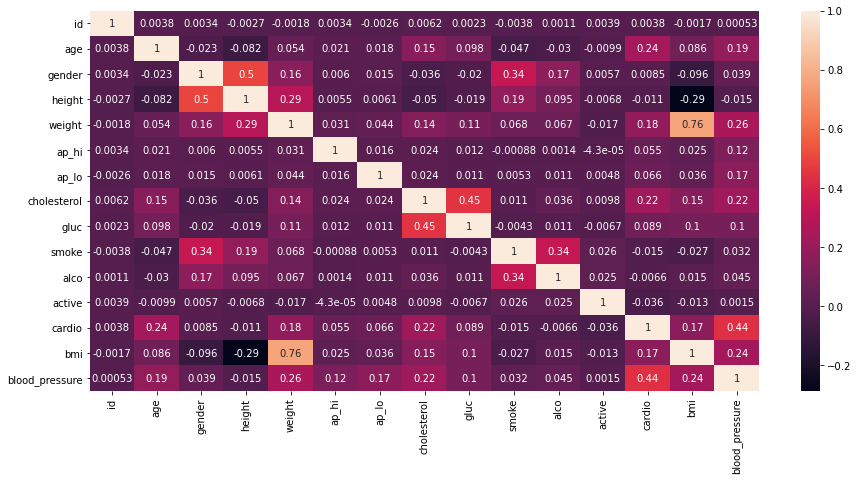

In [99]:
correlations = df4.corr(method='pearson')
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(correlations,ax=ax, annot=True);

# 4.0. Data Preparation

In [100]:
df4 = df3.copy()

## 4.1. Normalization

In [101]:
# define min max scaler
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

# transform weight - STD
df4['weight'] = scaler_mm.fit_transform(df4[['weight']].values)

# transform height - STD
df4['height'] = scaler_mm.fit_transform(df4[['height']].values)

# transform age - MM
df4['age'] = scaler_mm.fit_transform(df4[['age']].values)

# transform bmi - MM
df4['bmi'] = scaler_mm.fit_transform(df4[['bmi']].values)

df4

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,0,0.600000,2,0.579487,0.273684,110,80,1,1,0,0,1,0,0.061017,0.0
1,1,0.742857,1,0.517949,0.394737,140,90,3,1,0,0,1,1,0.105085,3.0
2,2,0.628571,1,0.564103,0.284211,130,70,3,1,0,0,0,1,0.067797,2.0
3,3,0.542857,2,0.584615,0.378947,150,100,1,1,0,0,1,1,0.084746,3.0
4,4,0.514286,1,0.517949,0.242105,100,60,1,1,0,0,0,0,0.067797,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,0.657143,2,0.579487,0.347368,120,80,1,1,1,0,1,0,0.077966,0.0
69996,99995,0.914286,1,0.528205,0.610526,140,90,2,2,0,0,1,1,0.159322,3.0
69997,99996,0.657143,2,0.656410,0.500000,180,90,3,1,0,1,0,1,0.094915,3.0
69998,99998,0.914286,1,0.553846,0.326316,135,80,1,2,0,0,0,1,0.081356,2.0


# 5.0. Feature Selection

In [102]:
df5 = df4.copy()

In [103]:
#drop id, ap_hi, ap_lo
df5 = df5.drop(['id'], axis=1)


X = df5.drop(['cardio'], axis=1)
y = df5['cardio'].copy()

In [104]:
#split dataset into train and test
x, x_test, y, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)
x_train, x_val, y_train, y_val = ms.train_test_split( x, y, test_size=0.2 )

## 5.1. Boruta as feature selector

In [105]:
#training and test dataset for Boruta
#x_train_n = x_train.values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

## 5.1.1 Best feature from Boruta

In [106]:
#cols_selected = boruta.support_.tolist()

#best feature
#x_train_fs = x_train
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
#cols_selected_boruta

#not selected from Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#cols_not_selected_boruta

# 6.0. Machine Learning Modeling

## 6.1. Linear Regression Model

In [107]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.663056,0.770002,0.776551


## 6.2. Linear Regression Regularized Model - Lasso

In [108]:
#model
lrr = Lasso(alpha = 0.2).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,0.801675,0.93098,0.851277


## 6.3. Random Forest Regressor

In [109]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.638354,0.741316,0.79135


## 6.4. XGBoost

In [110]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[11:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.710869,0.825527,0.774196


## 6.5. Neural Network - MLP

In [111]:
x_val.shape

(11176, 13)

In [112]:
#model definition
model = ml.Sequential()
model.add(l.Dense(11, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(1, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10000, callbacks=[es], verbose=1)

Epoch 1/10000
1397/1397 [==============================] - 7s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5016 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 2/10000
1397/1397 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5038 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 3/10000
1397/1397 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5019 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 4/10000
1397/1397 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5028 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 5/10000
1397/1397 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5006 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 6/10000
1397/1397 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5048 - val_loss: 0.0000e+00 - val_accuracy: 0.4930
Epoch 7/10000
1397/1397 [==============================] - 2s 1ms/step

In [113]:
##model evaluate
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)

print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc ))

Train ACC:0.501487672328949 - Val ACC:0.49302077293395996


In [114]:
#define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = d.PCA().fit(x_train)
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)

#change data to new space
pca = d.PCA(k).fit(x_train)

x_train = pca.transform(x_train)
x_val = pca.transform(x_val)

In [115]:
#ohe = pp.OneHotEncoder()
#y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
#y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()

In [116]:
#model definition
model = ml.Sequential()
model.add(l.Dense(11, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(1, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0)

In [117]:
##model evaluate
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)

print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc ))

Train ACC:0.501487672328949 - Val ACC:0.49302077293395996
